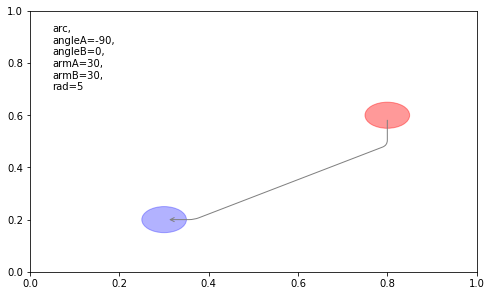

In [19]:
import matplotlib.pyplot as plt


def demo_con_style(ax, connectionstyle):
    

    
    
    
    x1, y1 = 0.3, 0.2
    x2, y2 = 0.8, 0.6

#     ax.plot([x1, x2], [y1, y2], ".")
        
    circle1 = plt.Circle((x1,y1), 0.05, color='b',alpha=0.3)
    circle2 = plt.Circle((x2,y2), 0.05, color='r',alpha=0.4)


    ax.add_patch(circle1)
    ax.add_patch(circle2)
    
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="0.5",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )

    ax.text(.05, .95, connectionstyle.replace(",", ",\n"),
            transform=ax.transAxes, ha="left", va="top")


fig, axs = plt.subplots(1,1, figsize=(8, 4.8))
# demo_con_style(axs[0, 0], "angle3,angleA=90,angleB=0")
# demo_con_style(axs[1, 0], "angle3,angleA=0,angleB=90")
# demo_con_style(axs[0, 1], "arc3,rad=0.")
# demo_con_style(axs[1, 1], "arc3,rad=0.3")
# demo_con_style(axs[2, 1], "arc3,rad=-0.3")
# demo_con_style(axs[0, 2], "angle,angleA=-90,angleB=180,rad=0")
# demo_con_style(axs[1, 2], "angle,angleA=-90,angleB=180,rad=5")
# demo_con_style(axs[2, 2], "angle,angleA=-90,angleB=10,rad=5")
# demo_con_style(axs[0, 3], "arc,angleA=-90,angleB=0,armA=30,armB=30,rad=0")
demo_con_style(axs, "arc,angleA=-90,angleB=0,armA=30,armB=30,rad=5")
# demo_con_style(axs[2, 3], "arc,angleA=-90,angleB=0,armA=0,armB=40,rad=0")
# demo_con_style(axs[0, 4], "bar,fraction=0.3")
# demo_con_style(axs[1, 4], "bar,fraction=-0.3")
# demo_con_style(axs[2, 4], "bar,angle=180,fraction=-0.2")

# for ax in axs.flat:
#     ax.set(xlim=(0, 1), ylim=(0, 1), xticks=[], yticks=[], aspect=1)
# fig.tight_layout(pad=0.2)



plt.show()

ModuleNotFoundError: No module named 'curlyBrace'

In [26]:
from gen import Tree, gentree
from operator import lt, gt
from sys import stdout

class DrawTree(object):
    def __init__(self, tree, parent=None, depth=0, number=1):
        self.x = -1.
        self.y = depth
        self.tree = tree
        self.children = [DrawTree(c, self, depth+1, i+1) 
                         for i, c
                         in enumerate(tree.children)]
        self.parent = parent
        self.thread = None
        self.mod = 0
        self.ancestor = self
        self.change = self.shift = 0
        self._lmost_sibling = None
        #this is the number of the node in its group of siblings 1..n
        self.number = number

    def left(self): 
        return self.thread or len(self.children) and self.children[0]

    def right(self):
        return self.thread or len(self.children) and self.children[-1]

    def lbrother(self):
        n = None
        if self.parent:
            for node in self.parent.children:
                if node == self: return n
                else:            n = node
        return n

    def get_lmost_sibling(self):
        if not self._lmost_sibling and self.parent and self != \
        self.parent.children[0]:
            self._lmost_sibling = self.parent.children[0]
        return self._lmost_sibling
    lmost_sibling = property(get_lmost_sibling)

    def __str__(self): return "%s: x=%s mod=%s" % (self.tree, self.x, self.mod)
    def __repr__(self): return self.__str__()

def buchheim(tree):
    dt = firstwalk(DrawTree(tree))
    min = second_walk(dt)
    if min < 0:
        third_walk(dt, -min)
    return dt

def third_walk(tree, n):
    tree.x += n
    for c in tree.children:
        third_walk(c, n)

def firstwalk(v, distance=1.):
    if len(v.children) == 0:
        if v.lmost_sibling:
            v.x = v.lbrother().x + distance
        else:
            v.x = 0.
    else:
        default_ancestor = v.children[0]
        for w in v.children:
            firstwalk(w)
            default_ancestor = apportion(w, default_ancestor, distance)
        print("finished v =", v.tree, "children")
        execute_shifts(v)

        midpoint = (v.children[0].x + v.children[-1].x) / 2

        ell = v.children[0]
        arr = v.children[-1]
        w = v.lbrother()
        if w:
            v.x = w.x + distance
            v.mod = v.x - midpoint
        else:
            v.x = midpoint
    return v

def apportion(v, default_ancestor, distance):
    w = v.lbrother()
    if w is not None:
        #in buchheim notation:
        #i == inner; o == outer; r == right; l == left; r = +; l = -
        vir = vor = v
        vil = w
        vol = v.lmost_sibling
        sir = sor = v.mod
        sil = vil.mod
        sol = vol.mod
        while vil.right() and vir.left():
            vil = vil.right()
            vir = vir.left()
            vol = vol.left()
            vor = vor.right()
            vor.ancestor = v
            shift = (vil.x + sil) - (vir.x + sir) + distance
            if shift > 0:
                move_subtree(ancestor(vil, v, default_ancestor), v, shift)
                sir = sir + shift
                sor = sor + shift
            sil += vil.mod
            sir += vir.mod
            sol += vol.mod
            sor += vor.mod
        if vil.right() and not vor.right():
            vor.thread = vil.right()
            vor.mod += sil - sor
        else:
            if vir.left() and not vol.left():
                vol.thread = vir.left()
                vol.mod += sir - sol
            default_ancestor = v
    return default_ancestor

def move_subtree(wl, wr, shift):
    subtrees = wr.number - wl.number
    print(wl.tree, "is conflicted with", wr.tree, 'moving', subtrees, 'shift', shift)
    #print wl, wr, wr.number, wl.number, shift, subtrees, shift/subtrees
    wr.change -= shift / subtrees
    wr.shift += shift
    wl.change += shift / subtrees
    wr.x += shift
    wr.mod += shift

def execute_shifts(v):
    shift = change = 0
    for w in v.children[::-1]:
        print("shift:", w, shift, w.change)
        w.x += shift
        w.mod += shift
        change += w.change
        shift += w.shift + change

def ancestor(vil, v, default_ancestor):
    #the relevant text is at the bottom of page 7 of
    #"Improving Walker's Algorithm to Run in Linear Time" by Buchheim et al, (2002)
    #http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.16.8757&rep=rep1&type=pdf
    if vil.ancestor in v.parent.children:
        return vil.ancestor
    else:
        return default_ancestor

def second_walk(v, m=0, depth=0, min=None):
    v.x += m
    v.y = depth

    if min is None or v.x < min:
        min = v.x

    for w in v.children:
        min = second_walk(w, m + v.mod, depth+1, min)

    return min

r = 30
rh = r*1.5
rw = r*1.5
stroke(0)

def drawt(root, depth):
    global r
    oval(root.x * rw, depth * rh, r, r)
    print(root.x)
    for child in root.children:
        drawt(child, depth+1)

def drawconn(root, depth):
    for child in root.children:
        line(root.x * rw + (r/2), depth * rh + (r/2),
             child.x * rw + (r/2), (depth+1) * rh + (r/2))
        drawconn(child, depth+1)

size(1000, 500)
translate(2, 2)
stroke(0)
drawconn(dt, 0)
fill(1,1,1)
drawt(dt, 0)

ImportError: cannot import name 'Tree' from 'gen' (/home/shong/.local/lib/python3.8/site-packages/gen/__init__.py)